# **Benchmark BM25**

In this notebook, I will be running some benchmark experiments in order to provide a solid baseline to compare my results using more advanced CoronaBERT strategies.  This notebook will make use of the BM25 term weightings.  It will be tested on the CORD-19 dataset as of 16/07/2020, in accordance with the documents available for Round 5 of TREC-COVID.  The relevance judgement - qrels - used to calculate ndcg scores will be our testing dataset - the relevance judgements made for Round 5 of the challenge.  I will be evaluating the methods on the standard measures used in Round 5 of TREC-COVID.

## **Setup**

### **Pyterrier**

In [ ]:
!pip install --upgrade python-terrier

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

In [ ]:
import pandas as pd
from tqdm import tqdm

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/round5_index_docs.zip?raw=true
!unzip -u "/content/round5_index_docs.zip?raw=true" -d "/content/index_docs"

Archive:  drive/My Drive/Level 4 Project/Dissertation Mark 2/Datasets/Cord19 Dataset/round5_index_docs.zip
   creating: /content/index_docs/content/terrier_cord19/
  inflating: /content/index_docs/content/terrier_cord19/data.document.fsarrayfile  
  inflating: /content/index_docs/content/terrier_cord19/data.lexicon.fsomapid  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.4  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.2  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.9  
  inflating: /content/index_docs/content/terrier_cord19/data.meta.zdata  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.8  
  inflating: /content/index_docs/content/terrier_cord19/data.direct.bf  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.5  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.7  
  inflating: /content/index

In [ ]:
index = pt.IndexFactory.of("/content/index_docs/content/terrier_cord19/data.properties")

In [ ]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
topics = cord19.get_topics('title')

/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


### **TREC Datasets**

In [ ]:
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
!wget https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j4.5-5.txt

--2022-02-09 12:19:40--  https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 763591 (746K) [text/plain]
Saving to: ‘qrels-covid_d4_j0.5-4.txt.1’

qrels-covid_d4_j0.5 100%[===================>] 745.69K   818KB/s    in 0.9s    

2022-02-09 12:19:41 (818 KB/s) - ‘qrels-covid_d4_j0.5-4.txt.1’ saved [763591/763591]

--2022-02-09 12:19:41--  https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34087 (33K) [text/csv]
Saving to: ‘changedIds-Jul16.csv.1’

changedIds-Jul16.cs 100%[===================>]  33.29K  --.-KB/s    in 0.03s   

2022-02-09 12:19:41 (993 KB/s) - ‘changedIds-Jul16.csv.1

In [ ]:
import csv

cord_remapping = {}
with open('changedIds-Jul16.csv') as f:
  reader = csv.DictReader(f)
  for row in reader:
    cord_remapping[row['cord_uid_0619']] = row['cord_uid_0716']
len(cord_remapping)

1135

In [ ]:
from collections import Counter,defaultdict

training_judgments_by_topic = defaultdict(dict)
with open('qrels-covid_d4_j0.5-4.txt') as f:
  for line in f:
    topic_id,round_id,doc_id,relevance = line.strip('\n').split()
    topic_id = int(topic_id)
    relevance = int(relevance)
    
    if doc_id in cord_remapping:
      doc_id = cord_remapping[doc_id]

    training_judgments_by_topic[topic_id][doc_id] = relevance


In [ ]:
from collections import defaultdict
qrels = defaultdict(dict)
with open('qrels-covid_d5_j4.5-5.txt') as f:
  for line in f:
    topic_id,iteration,doc_id,judgement = line.strip('\n').split()
    topic_id = int(topic_id)
    judgement = int(judgement)
    qrels[topic_id][doc_id] = judgement

In [ ]:
test_qrels = []
for qid in qrels:
  for docno, judgement in qrels[qid].items():
    test_qrels.append([str(qid), docno, judgement])

test_qrels = pd.DataFrame(test_qrels, columns=['qid', 'docno', 'label'])

## **Experiments**

In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
pl2 = pt.BatchRetrieve(index, wmodel="PL2")

In [ ]:
sys_scores = {}

results = []


topic_ids = list(range(1, 51))

for topic_id in tqdm(topic_ids):
  query = topics[topics['qid']==str(topic_id)].iloc[0]['query']
  
  doc_ids_to_exclude = training_judgments_by_topic[topic_id]
  
  result = bm25(query)
   
 
  doc_scores_with_ids = list(zip(result.score,result.docno))
  doc_scores_with_ids = [ (score,doc_id) for score,doc_id in doc_scores_with_ids if not doc_id in doc_ids_to_exclude ]
  doc_scores_with_ids = sorted(doc_scores_with_ids, reverse=True, key=lambda x:x[0])

  sys_scores[topic_id] = doc_scores_with_ids[:1000]

scores = []

for qid in sys_scores:
  rank = 0
  for pair in sys_scores[qid]:
    scores.append([str(qid), pair[1], pair[0], rank])
    rank += 1

bm25_results = pd.DataFrame(scores, columns=['qid', 'docno', 'score', 'rank'])

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
100%|██████████| 50/50 [00:03<00:00, 15.48it/s]


In [ ]:
sys_scores = {}

results = []


topic_ids = list(range(1, 51))

for topic_id in tqdm(topic_ids):
  query = topics[topics['qid']==str(topic_id)].iloc[0]['query']
  
  doc_ids_to_exclude = training_judgments_by_topic[topic_id]
  
  result = tf_idf(query)
   
 
  doc_scores_with_ids = list(zip(result.score,result.docno))
  doc_scores_with_ids = [ (score,doc_id) for score,doc_id in doc_scores_with_ids if not doc_id in doc_ids_to_exclude ]
  doc_scores_with_ids = sorted(doc_scores_with_ids, reverse=True, key=lambda x:x[0])

  sys_scores[topic_id] = doc_scores_with_ids[:1000]

scores = []

for qid in sys_scores:
  rank = 0
  for pair in sys_scores[qid]:
    scores.append([str(qid), pair[1], pair[0], rank])
    rank += 1

tfidf_results = pd.DataFrame(scores, columns=['qid', 'docno', 'score', 'rank'])

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
100%|██████████| 50/50 [00:04<00:00, 10.31it/s]


In [ ]:
sys_scores = {}

results = []


topic_ids = list(range(1, 51))

for topic_id in tqdm(topic_ids):
  query = topics[topics['qid']==str(topic_id)].iloc[0]['query']
  
  doc_ids_to_exclude = training_judgments_by_topic[topic_id]
  
  result = pl2(query)
   
 
  doc_scores_with_ids = list(zip(result.score,result.docno))
  doc_scores_with_ids = [ (score,doc_id) for score,doc_id in doc_scores_with_ids if not doc_id in doc_ids_to_exclude ]
  doc_scores_with_ids = sorted(doc_scores_with_ids, reverse=True, key=lambda x:x[0])

  sys_scores[topic_id] = doc_scores_with_ids[:1000]

scores = []

for qid in sys_scores:
  rank = 0
  for pair in sys_scores[qid]:
    scores.append([str(qid), pair[1], pair[0], rank])
    rank += 1

pl2_results = pd.DataFrame(scores, columns=['qid', 'docno', 'score', 'rank'])

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


In [ ]:
from pyterrier.measures import *

eval_results = pt.Experiment([
  bm25_results, 
  tfidf_results,
  pl2_results
  ],
  topics,
  test_qrels,
  names=["BM25", "TF_IDF", "PL2"],
  eval_metrics=["ndcg", "ndcg_cut.20", P@20, Bpref, 'map']
)

In [ ]:
print(eval_results.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
  name &     ndcg &  ndcg\_cut.20 &  P@20 &    Bpref &      map \\
\midrule
  BM25 & 0.371217 &     0.465319 & 0.490 & 0.322114 & 0.160014 \\
TF\_IDF & 0.364795 &     0.461126 & 0.489 & 0.317738 & 0.155869 \\
   PL2 & 0.354813 &     0.441761 & 0.463 & 0.309434 & 0.148338 \\
\bottomrule
\end{tabular}



In [ ]:
df = bm25(topics).head()

In [ ]:
df = df[['qid', 'docno', 'rank', 'score']]
print(df.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
qid &    docno &  rank &     score \\
\midrule
  1 & zy8qjaai &     0 & 11.915479 \\
  1 & 8ccl9aui &     1 & 11.550953 \\
  1 & ne5r4d4b &     2 & 11.268729 \\
  1 & 75773gwg &     3 & 11.165944 \\
  1 & kn2z7lho &     4 & 11.165944 \\
\bottomrule
\end{tabular}



## **Results**

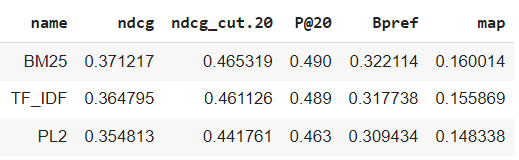